# Impact Function Calibration

CLIMADA provides the [`climada.util.calibrate`](calibration-module) module for calibrating impact functions based on impact data.
This tutorial will guide through the usage of this module by calibrating an impact function for tropical cyclones (TCs).

For further information on the classes available from the module, see its [documentation](calibration-module).

## Overview

The basic idea of the calibration is to find a set of parameters for an impact function that minimizes the deviation between the calculated impact and some impact data.
For setting up a calibration task, users have to supply the following information:

* Hazard and Exposure (as usual, see [the tutorial](1_main_climada.ipynb#tutorial-an-example-risk-assessment))
* The impact data to calibrate the model to
* An impact function definition depending on the calibrated parameters
* Bounds and constraints of the calibrated parameters (depending on the calibration algorithm)
* A "cost function" defining the single-valued deviation between impact data and calculated impact
* A function for transforming the calculated impact into the same data structure as the impact data

This information defines the calibration task and is inserted into the {py:class}`~climada.util.calibrate.base.Input` object.
Afterwards, the user may insert this object into one of the optimizer classes.
Currently, the following classes are available:

* {py:class}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizer`: Uses Bayesian optimization to sample the parameter space.
* {py:class}`~climada.util.calibrate.scipy_optimizer.ScipyMinimizeOptimizer`: Uses the [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function for determining the best parameter set.

The following tutorial walks through the input data preparation and the setup of a {py:class}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizer` instance for calibration.
For a brief example, refer to [Quickstart](#quickstart).
If you want to go through a somewhat realistic calibration task step-by-step, continue with [Calibration Data](#calibration-data).

In [1]:
import logging
import climada

logging.getLogger("climada").setLevel("WARNING")

### Quickstart

This section gives a very quick overview of assembling a calibration task.
Here, we calibrate a single impact function for damage reports in Mexico (`MEX`) from a TC with IbtracsID `2010176N16278`.

{'v_half': 48.30330871103452}

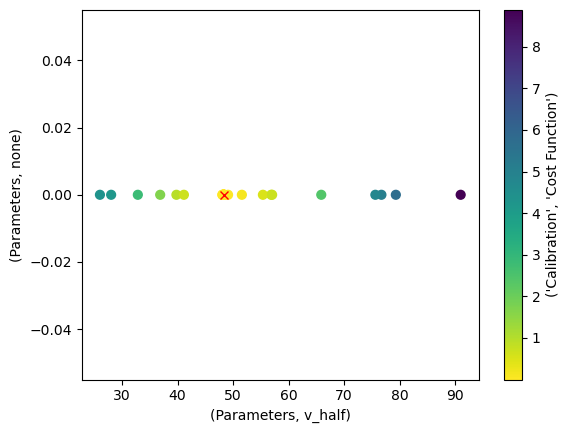

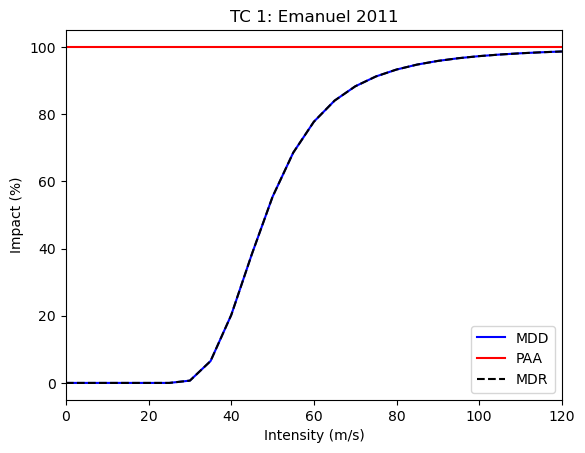

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_log_error

from climada.util import log_level
from climada.util.api_client import Client
from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.util.calibrate import (
    Input,
    BayesianOptimizer,
    BayesianOptimizerController,
    OutputEvaluator,
)

# Load hazard and exposure from Data API
client = Client()
exposure = client.get_litpop("MEX")
exposure.gdf["impf_TC"] = 1
all_tcs = client.get_hazard(
    "tropical_cyclone",
    properties={"event_type": "observed", "spatial_coverage": "global"},
)
hazard = all_tcs.select(event_names=["2010176N16278"])

# Impact data (columns: region ID, index: hazard event ID)
data = pd.DataFrame(data=[[2.485465e09]], columns=[484], index=list(hazard.event_id))

# Create input
inp = Input(
    hazard=hazard,
    exposure=exposure,
    data=data,
    # Generate impact function from estimated parameters
    impact_func_creator=lambda v_half: ImpactFuncSet(
        [ImpfTropCyclone.from_emanuel_usa(v_half=v_half, impf_id=1)]
    ),
    # Estimated parameter bounds
    bounds={"v_half": (26, 100)},
    # Cost function
    cost_func=mean_squared_log_error,
    # Transform impact to pandas Dataframe with same structure as data
    impact_to_dataframe=lambda impact: impact.impact_at_reg(exposure.gdf["region_id"]),
)

# Set up optimizer (with controller)
controller = BayesianOptimizerController.from_input(inp)
opt = BayesianOptimizer(inp)

# Run optimization
with log_level("WARNING", "climada.engine.impact_calc"):
    output = opt.run(controller=controller)

# Analyse results
output.plot_p_space()
out_eval = OutputEvaluator(inp, output)
out_eval.impf_set.plot()

# Optimal value
output.params

Follow the next sections of the tutorial for a more in-depth explanation.

## Calibration Data

CLIMADA ships data from the International Disaster Database EM-DAT, which we will use to calibrate impact functions on.
In the first step, we will select TC events that caused damages in the `NA1` basin since 2010.

We use EMDAT data from TCs occurring in the `NA1` basin since 2010.
We calculate the centroids for which we want to compute the windfields by extracting the countries hit by the cyclones and retrieving a `LitPop` exposure instance from them.
We then use the exposure coordinates as centroids coordinates.

In [3]:
import pandas as pd
from climada.util.constants import SYSTEM_DIR

emdat = pd.read_csv(SYSTEM_DIR / "tc_impf_cal_v01_EDR.csv")
emdat_subset = emdat[(emdat["cal_region2"] == "NA1") & (emdat["year"] >= 2010)]
emdat_subset

,country,region_id,cal_region2,year,EM_ID,ibtracsID,emdat_impact,reference_year,emdat_impact_scaled,climada_impact,...,scale,log_ratio,unique_ID,Associated_disaster,Surge,Rain,Flood,Slide,Other,OtherThanSurge
326,MEX,484,NA1,2010,2010-0260,2010176N16278,2.000000e+09,2014,2.485465e+09,2.478270e+09,...,1.0,-0.002899,2010-0260MEX,True,False,False,True,False,False,True
331,ATG,28,NA1,2010,2010-0468,2010236N12341,1.260000e+07,2014,1.394594e+07,1.402875e+07,...,1.0,0.005920,2010-0468ATG,True,False,False,True,False,False,True
334,MEX,484,NA1,2010,2010-0494,2010257N16282,3.900000e+09,2014,4.846656e+09,4.857140e+09,...,1.0,0.002161,2010-0494MEX,True,False,False,True,False,False,True
339,LCA,662,NA1,2010,2010-0571,2010302N09306,5.000000e+05,2014,5.486675e+05,5.492871e+05,...,1.0,0.001129,2010-0571LCA,True,False,False,True,True,False,True
340,VCT,670,NA1,2010,2010-0571,2010302N09306,2.500000e+07,2014,2.670606e+07,2.676927e+07,...,1.0,0.002364,2010-0571VCT,False,False,False,False,False,False,False
344,BHS,44,NA1,2011,2011-0328,2011233N15301,4.000000e+07,2014,4.352258e+07,4.339898e+07,...,1.0,-0.002844,2011-0328BHS,False,False,False,False,False,False,False
345,DOM,214,NA1,2011,2011-0328,2011233N15301,3.000000e+07,2014,3.428317e+07,3.404744e+07,...,1.0,-0.006900,2011-0328DOM,True,False,False,True,False,False,True
346,PRI,630,NA1,2011,2011-0328,2011233N15301,5.000000e+08,2014,5.104338e+08,5.139659e+08,...,1.0,0.006896,2011-0328PRI,True,False,False,True,False,False,True
352,MEX,484,NA1,2011,2011-0385,2011279N10257,2.770000e+07,2014,3.084603e+07,3.077374e+07,...,1.0,-0.002346,2011-0385MEX,True,False,False,True,True,False,True
359,MEX,484,NA1,2012,2012-0276,2012215N12313,3.000000e+08,2014,3.283428e+08,3.284805e+08,...,1.0,0.000419,2012-0276MEX,False,False,False,False,False,False,False


Each entry in the database refers to an economic impact for a specific country and TC event.
The TC events are identified by the ID assigned from the International Best Track Archive for Climate Stewardship (IBTrACS).
We now want to reshape this data so that impacts are grouped by event and country.

To achieve this, we iterate over the unique track IDs, select all reported damages associated with this ID, and concatenate the results.
For missing entries, `pandas` will set the value to NaN.
We assume that missing entries means that no damages are reported (this is a strong assumption), and set all NaN values to zero.
Then, we transpose the dataframe so that each row represents an event and each column states the damage for a specific country.
Finally, we set the track ID to be the index of the data frame.

In [4]:
track_ids = emdat_subset["ibtracsID"].unique()

data = pd.pivot_table(
    emdat_subset,
    values="emdat_impact_scaled",
    index="ibtracsID",
    columns="region_id",
    # fill_value=0,
)
data

region_id,28,44,92,132,192,212,214,388,484,630,659,662,670,796
ibtracsID,,,,,,,,,,,,,,
2010176N16278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.485465e+09,NaN,NaN,NaN,NaN,NaN
2010236N12341,1.394594e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010257N16282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.846656e+09,NaN,NaN,NaN,NaN,NaN
2010302N09306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,548667.5019,26706058.15,NaN
2011233N15301,NaN,4.352258e+07,NaN,NaN,NaN,NaN,34283168.75,NaN,NaN,5.104338e+08,NaN,NaN,NaN,NaN
2011279N10257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.084603e+07,NaN,NaN,NaN,NaN,NaN
2012166N09269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.074341e+08,NaN,NaN,NaN,NaN,NaN
2012215N12313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.283428e+08,NaN,NaN,NaN,NaN,NaN
2012296N14283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15483975.86,NaN,NaN,NaN,NaN,NaN,NaN


This is the data against which we want to compare our model output.
Let's continue setting up the calibration!

## Model Setup

In the first step, we create the exposure layer for the model.
We use the {py:class}`~climada.entity.exposures.litpop.litpop.LitPop` module and simply pass the names of all countries listed in our calibration data to the {py:meth}`~climada.entity.exposures.litpop.litpop.LitPop.from_countries` classmethod.
The countries are the columns in the `data` object.

Alternatively, we could have inserted `emdat_subset["region_id"].unique().tolist()`.

In [5]:
# from climada.entity.exposures.litpop import LitPop
# from climada.util import log_level

# # Calculate the exposure
# with log_level("ERROR"):
#     exposure = LitPop.from_countries(data.columns.tolist())

In [6]:
from climada.util.api_client import Client
from climada.entity.exposures.litpop import LitPop
from climada.util.coordinates import country_to_iso

client = Client()
exposure = LitPop.concat(
    [
        client.get_litpop(country_to_iso(country_id, representation="alpha3"))
        for country_id in data.columns
    ]
)

In [7]:
from climada.util.api_client import Client

client = Client()
tc_dataset_infos = client.list_dataset_infos(data_type="tropical_cyclone")
client.get_property_values(
    client.list_dataset_infos(data_type="tropical_cyclone"),
    known_property_values={"event_type": "observed", "spatial_coverage": "global"},
)

{'res_arcsec': ['150'],
 'event_type': ['observed'],
 'spatial_coverage': ['global'],
 'climate_scenario': ['None']}

We will use the CLIMADA Data API to download readily computed wind fields from TC tracks.
The API provides a large dataset containing all historical TC tracks.
We will download them and then select the subset of TCs for which we have impact data by using {py:meth}`~climada.hazard.base.Hazard.select`.

In [8]:
from climada.util.api_client import Client

client = Client()
all_tcs = client.get_hazard(
    "tropical_cyclone",
    properties={"event_type": "observed", "spatial_coverage": "global"},
)
hazard = all_tcs.select(event_names=track_ids.tolist())

**NOTE:** Discouraged! This will usually take a longer time than using the Data API

Alternatively, CLIMADA provides the {py:class}`~climada.hazard.tc_tracks.TCTracks` class, which lets us download the tracks of TCs using their IBTrACS IDs.
We then have to equalize the time steps of the different TC tracks.

The track and intensity of a cyclone are insufficient to compute impacts in CLIMADA.
We first have to re-compute a windfield from each track at the locations of interest.
For consistency, we simply choose the coordinates of the exposure.

In [9]:
# NOTE: Uncomment this to compute wind fields yourself

# from climada.hazard import Centroids, TCTracks, TropCyclone

# # Get the tracks for associated TCs
# tracks = TCTracks.from_ibtracs_netcdf(storm_id=track_ids.tolist())
# tracks.equal_timestep(time_step_h=1.0, land_params=False)
# tracks.plot()

# # Calculate windfield for the tracks
# centroids = Centroids.from_lat_lon(exposure.gdf['latitude'], exposure.gdf['longitude'])
# hazard = TropCyclone.from_tracks(tracks, centroids)

## Calibration Setup

We are now set up to define the specifics of the calibration task.
First, let us define the impact function we actually want to calibrate.
We select the formula by Emanuel (2011), for which a shortcut exists in the CLIMADA code base: {py:meth}`~climada.entity.impact_funcs.trop_cyclone.ImpfTropCyclone.from_emanuel_usa`.
The sigmoid-like impact function takes three parameters, the wind threshold for any impact `v_thresh`, the wind speed where half of the impact occurs `v_half`, and the maximum impact factor `scale`.
According to the model by Emanuel (2011), `v_thresh` is considered a constant, so we choose to only calibrate the latter two.

Any CLIMADA {py:class}`~climada.util.calibrate.base.Optimizer` will roughly perform the following algorithm:
1. Create a set of parameters and built an impact function (set) from it.
2. Compute an impact with that impact function set.
3. Compare the impact and the calibration data via the cost/target function.
4. Repeat N times or until the target function goal is reached.

The selection of parameters is based on the target function varies strongly between different optimization algorithms.

For the first step, we have to supply a function that takes the parameters we try to estimate and returns the impact function set that can later be used in an impact calculation.
We only calibrate a single function for the entire basin, so this is straightforward.

To ensure the impact function is applied correctly, we also have to set the `impf_` column of the exposure `GeoDataFrame`.
Note that the default impact function ID is 1, and that the hazard type is `"TC"`.

In [10]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

# Match impact function and exposure
exposure.gdf["impf_TC"] = 1


def impact_func_tc(v_half, scale):
    return ImpactFuncSet([ImpfTropCyclone.from_emanuel_usa(v_half=v_half, scale=scale)])

We will be using the {py:class}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizer`, which requires very little information on the parameter space beforehand.
One crucial information are the bounds of the parameters, though.
Initial values are not needed because the optimizer first samples the bound parameter space uniformly and then iteratively "narrows down" the search.
We choose a `v_half` between `v_thresh` and 150, and a scale between 0.01 (it must never be zero) and 1.0.
Specifying the bounds as dictionary (a must in case of `BayesianOptimizer`) also serves the purpose of naming the parameters we want to calibrate.
Notice that these names have to match the arguments of the impact function generator.

In [11]:
bounds = {"v_half": (25.8, 150), "scale": (0.01, 1)}

Defining the cost function is crucial for the result of the calibration.
You can choose what is best suited for your application.
Often, it is not clear which function works best, and it's a good idea to try out a few.
Because the impacts of different events may vary over several orders of magnitude, we select the mean squared logartihmic error (MSLE).
This one and other error measures are readily supplied by the `sklearn` package.

The cost function must be defined as a function that takes the impact object calculated by the optimization algorithm and the input calibration data as arguments, and that returns a single number.
This number represents a "cost" of the parameter set used for calculating the impact.
A higher cost therefore is worse, a lower cost is better.
Any optimizer will try to minimize the cost.

Note that the impact object is an instance of `Impact`, whereas the input calibration data is a `pd.DataFrame`.
To compute the MSLE, we first have to transform the impact into the same data structure, meaning that we have to aggregate the point-wise impacts by event and country.
The function performing this transformation task is provided to the {py:class}`~climada.util.calibrate.base.Input` via its {py:attr}`~climada.util.calibrate.base.Input.impact_to_dataframe` attribute.
Here we choose {py:meth}`climada.engine.impact.Impact.impact_at_reg`, which aggregates over countries by default.
To improve performance, we can supply this function with our known region IDs instead of re-computing them in every step.

Computations on data frames align columns and indexes.
The indexes of the calibration data are the IBTrACS IDs, but the indexes of the result of `impact_at_reg` are the hazard event IDs, which at this point are only integer numbers.
To resolve that, we adjust our calibration dataframe to carry the respective `Hazard.event_id` as index.

In [12]:
data = data.rename(
    index={
        hazard.event_name[idx]: hazard.event_id[idx]
        for idx in range(len(hazard.event_id))
    }
)
data.index.rename("event_id", inplace=True)
data

region_id,28,44,92,132,192,212,214,388,484,630,659,662,670,796
event_id,,,,,,,,,,,,,,
1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.485465e+09,NaN,NaN,NaN,NaN,NaN
1339,1.394594e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.846656e+09,NaN,NaN,NaN,NaN,NaN
1351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,548667.5019,26706058.15,NaN
1361,NaN,4.352258e+07,NaN,NaN,NaN,NaN,34283168.75,NaN,NaN,5.104338e+08,NaN,NaN,NaN,NaN
3686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.084603e+07,NaN,NaN,NaN,NaN,NaN
3691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.074341e+08,NaN,NaN,NaN,NaN,NaN
1377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.283428e+08,NaN,NaN,NaN,NaN,NaN
1390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15483975.86,NaN,NaN,NaN,NaN,NaN,NaN


## Execute the Calibration

We created a class {py:class}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerController` to control and guide the calibration process.
It is intended to walk through several optimization iterations and stop the process if the best guess cannot be improved.
The optimization works as follows:

1. The optimizer randomly samples the parameter space {py:attr}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerController.init_points` times.
2. The optimizer uses a Gaussian regression process to "smartly" sample the parameter space at most {py:attr}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerController.n_iter` times.
   * The process uses an "Upper Confidence Bound" sampling method whose parameter {py:attr}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerController.kappa` indicates how close the sampled points are to the buest guess.
     Higher `kappa` means more exploration of the parameter space, lower `kappa` means more exploitation.
   * After each sample, the parameter `kappa` is reduced by the factor `kappa_decay`.
     By default, this parameter is set such that `kappa` equals {py:attr}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerController.kappa_min` at the last step.
     This way, the sampling becomes more exploitative the more steps are taken.
3. The controller tracks the improvements of the buest guess for parameters.
   If {py:attr}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerController.min_improvement_count` consecutive improvements are lower than {py:attr}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerController.min_improvement`, the smart sampling is stopped.
   In this case, the `iterations` count is increased and the process repeated from step 1.
4. If an entire iteration did not show any improvement, the optimization is stopped.
   It is also stopped when the {py:attr}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerController.max_iterations` count is reached.

Users can control the "density", and thus the accuracy of the sampling by adjusting the controller parameters.
Increasing `init_points`, `n_iter`, `min_improvement_count`, and `max_iterations`, and decreasing `min_improvement` generally increases density and accuracy, but leads to longer runtimes.

We suggest using the `from_input` classmethod for a convenient choice of sampling density based on the parameter space.
The two parameters `init_points` and `n_iter` are set to $b^N$, where $N$ is the number of estimated parameters and $b$ is the `sampling_base` parameter, which defaults to 4.

Now we can finally execute our calibration task!
We will plug all input parameters in an instance of `Input`, and then create the optimizer instance with it.
The `Optimizer.run` method returns an {py:class}`~climada.util.calibrate.base.Output` object, whose {py:attr}`~climada.util.calibrate.base.Output.params` attribute holds the optimal parameters determined by the calibration.

Notice that the `BayesianOptimization` *maximizes* a target function.
Therefore, higher target values are *better* than lower ones in this case.

In [ ]:
from climada.util.calibrate import Input, BayesianOptimizer, BayesianOptimizerController
from sklearn.metrics import mean_squared_log_error

from climada.util import log_level

# Define calibration input
with log_level("INFO", name_prefix="climada.util.calibrate"):
    input = Input(
        hazard=hazard,
        exposure=exposure,
        data=data,
        impact_func_creator=impact_func_tc,
        cost_func=mean_squared_log_error,
        impact_to_dataframe=lambda imp: imp.impact_at_reg(exposure.gdf["region_id"]),
        bounds=bounds,
    )

    # Create and run the optimizer
    opt = BayesianOptimizer(input)
    controller = BayesianOptimizerController.from_input(input)
    bayes_output = opt.run(controller=controller)
    bayes_output.params  # The optimal parameters

2025-04-25 14:26:34,488 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 0
2025-04-25 14:26:36,470 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 1
2025-04-25 14:26:38,750 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 2
2025-04-25 14:26:41,150 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 3
2025-04-25 14:26:43,701 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 4
2025-04-25 14:26:46,994 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 5
2025-04-25 14:26:51,476 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 6
2025-04-25 14:26:55,846 - climada.util.calibrate.bayesian_optimizer - INFO - No improvement. Stop optimization.


## Evaluate Output

The Bayesian Optimizer returns the entire paramter space it sampled via {py:class}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerOutput`
We can find out a lot about the relation of the fitted parameters by investigating how the cost function value depends on them.
We can retrieve the parameter space as `pandas.DataFrame` via {py:meth}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerOutput.p_space_to_dataframe`.
This dataframe has MultiIndex columns.
One group are the `Parameters`, the other holds information on the `Calibration` for each parameter set.
Notice that the optimal parameter set is not necessarily the last entry in the parameter space!

In [14]:
p_space_df = bayes_output.p_space_to_dataframe()
p_space_df

Parameters               Calibration
               scale      v_half Cost Function
Iteration                                     
0           0.422852  115.264302      2.726950
1           0.010113   63.349706      4.133135
2           0.155288   37.268453      0.800611
3           0.194398   68.718642      1.683610
4           0.402800   92.721038      2.046407
...              ...         ...           ...
219         0.711722   51.676720      0.773888
220         0.920148   48.767231      0.771611
221         0.903950   50.001948      0.765957
222         1.000000   52.968129      0.764202
223         0.799534   49.721017      0.765107

[224 rows x 3 columns]

In contrast, the controller only tracks the consecutive improvements of the best guess.

In [15]:
controller.improvements()

,iteration,random,target,improvement
sample,,,,
0,0,True,-2.726950,inf
2,0,True,-0.800611,2.406088
24,0,False,-0.793780,0.008605
29,0,False,-0.791065,0.003432
40,1,False,-0.781115,0.012737
44,1,False,-0.777910,0.004119
48,1,False,-0.774136,0.004876
60,1,False,-0.773844,0.000377
81,2,False,-0.770928,0.003782


To get one group of the columns, simply access the item.

In [16]:
p_space_df["Parameters"]

,scale,v_half
Iteration,,
0,0.422852,115.264302
1,0.010113,63.349706
2,0.155288,37.268453
3,0.194398,68.718642
4,0.402800,92.721038
...,...,...
219,0.711722,51.676720
220,0.920148,48.767231
221,0.903950,50.001948


Notice that the optimal parameter set is not necessarily the last entry in the parameter space!
Therefore, let's order the parameter space by the ascending cost function values.

In [17]:
p_space_df = p_space_df.sort_values(("Calibration", "Cost Function"), ascending=True)
p_space_df

Parameters               Calibration
               scale      v_half Cost Function
Iteration                                     
189         1.000000   52.392756      0.763910
178         1.000000   52.176366      0.763951
185         1.000000   52.647236      0.763968
222         1.000000   52.968129      0.764202
180         1.000000   51.656630      0.764398
...              ...         ...           ...
139         0.081255  145.935720      5.822272
35          0.028105  118.967924      6.298332
97          0.012842  102.449398      6.635728
204         0.031310  143.537900      7.262185
101         0.025663  141.236104      7.504095

[224 rows x 3 columns]

The {py:class}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerOutput` supplies the {py:meth}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerOutput.plot_p_space` method for convenience.
If there were more than two parameters we calibrated, it would produce a plot for each parameter combination.

<Axes: xlabel='(Parameters, v_half)', ylabel='(Parameters, scale)'>

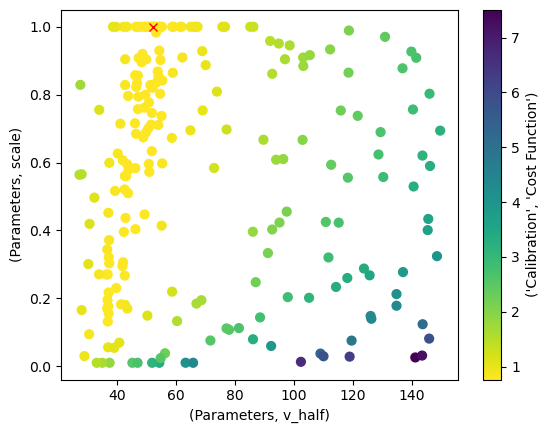

In [18]:
bayes_output.plot_p_space(x="v_half", y="scale")

In [19]:
p_space_df["Parameters"].iloc[0, :].to_dict()

{'scale': 1.0, 'v_half': 52.39275573380861}

## Analyze the Calibration

Now that we obtained a calibration result, we should investigate it further.
The tasks of evaluating results and plotting them is simplified by the {py:class}`~climada.util.calibrate.base.OutputEvaluator`.
It takes the input and output of a calibration task as parameters.
Let's start by plotting the optimized impact function:

<Axes: title={'center': 'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

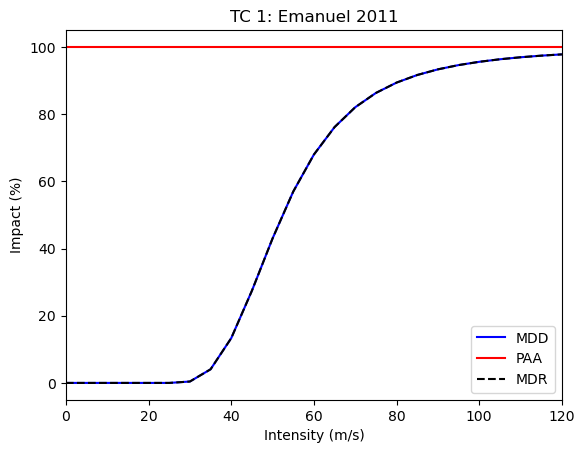

In [20]:
from climada.util.calibrate import OutputEvaluator

output_eval = OutputEvaluator(input, bayes_output)
output_eval.impf_set.plot()

Here we show how the variability in parameter combinations with similar cost function values (as seen in the plot of the parameter space) translate to varying impact functions. In addition, the hazard value distribution is shown. Together this provides an intuitive overview regarding the robustness of the optimization, given the chosen cost function. It does NOT provide a view of the sampling uncertainty (as e.g. bootstrapping or cross-validation) NOR of the suitability of the cost function which is chosen by the user.

This functionality is only available from the {py:class}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerOutputEvaluator` tailored to Bayesian optimizer outputs.
It includes all function from {py:class}`~climada.util.calibrate.base.OutputEvaluator`.

<Axes: xlabel='Intensity (m/s)', ylabel='Mean Damage Ratio (MDR)'>

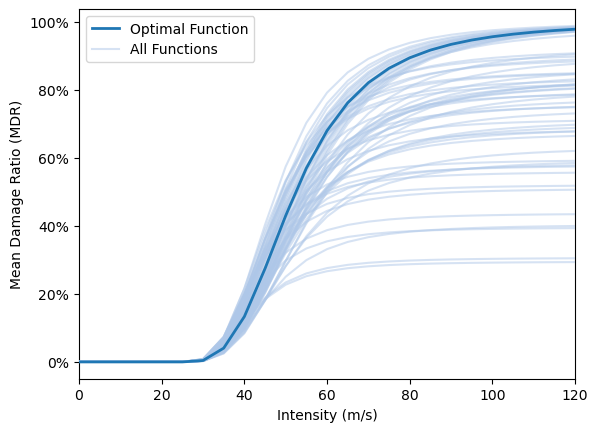

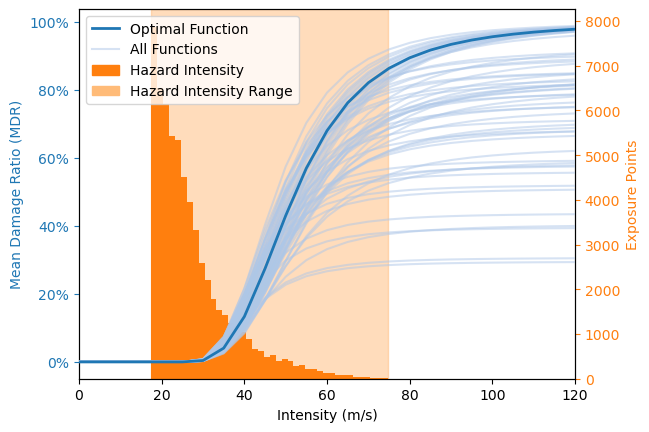

In [21]:
from climada.util.calibrate import BayesianOptimizerOutputEvaluator, select_best

output_eval = BayesianOptimizerOutputEvaluator(input, bayes_output)

# Plot the impact function variability
output_eval.plot_impf_variability(select_best(p_space_df, 0.03), plot_haz=False)
output_eval.plot_impf_variability(select_best(p_space_df, 0.03))

The target function has limited meaning outside the calibration task.
To investigate the quality of the calibration, it is helpful to compute the impact with the impact function defined by the optimal parameters.
The {py:class}`~climada.util.calibrate.base.OutputEvaluator` readily computed this impact when it was created.
You can access the impact via the {py:attr}`~climada.util.calibrate.base.OutputEvaluator.impact` attribute.

In [22]:
import numpy as np

impact_data = output_eval.impact.impact_at_reg(exposure.gdf["region_id"])
impact_data.set_index(np.asarray(hazard.event_name), inplace=True)
impact_data

,28,44,92,132,192,212,214,388,484,630,659,662,670,796
2010176N16278,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.629343e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2010236N12341,2.362421e+07,0.000000e+00,6.273895e+07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.489799e+07,1.243066e+07,0.000000e+00,0.000000e+00,0.000000e+00
2010257N16282,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.210669e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2010302N09306,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.668112e+06,4.537917e+06,6.931670e+05
2011233N15301,0.000000e+00,1.221974e+09,2.344844e+07,0.000000,0.000000e+00,0.000000e+00,7.044665e+04,0.000000e+00,0.000000e+00,7.033207e+08,0.000000e+00,0.000000e+00,0.000000e+00,1.374375e+08
2011279N10257,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.687471e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2012215N12313,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.564085e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2012166N09269,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.890366e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2012296N14283,0.000000e+00,1.311881e+08,0.000000e+00,0.000000,2.742997e+09,0.000000e+00,0.000000e+00,3.077018e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2014253N13260,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.353240e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


We can now compare the modelled and reported impact data on a country- or event-basis.
The `OutputEvaluator` also has methods for that.
In both of these, you can supply a transformation function with the `data_transf` argument.
This transforms the data to be plotted right before plotting.
Recall that we set the event IDs as index for the data frames.
To better interpret the results, it is useful to transform them into event names again, which are the IBTrACS IDs.
Likewise, we use the region IDs for region identification.
It might be nicer to transform these into country names before plotting.

In [23]:
import climada.util.coordinates as u_coord


def country_code_to_name(code):
    return u_coord.country_to_iso(code, representation="name")


event_id_to_name = {
    hazard.event_id[idx]: hazard.event_name[idx] for idx in range(len(hazard.event_id))
}

<Axes: ylabel='Impact [USD]'>

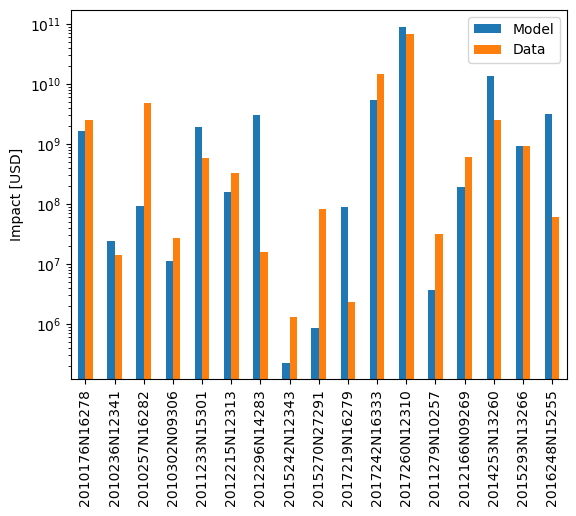

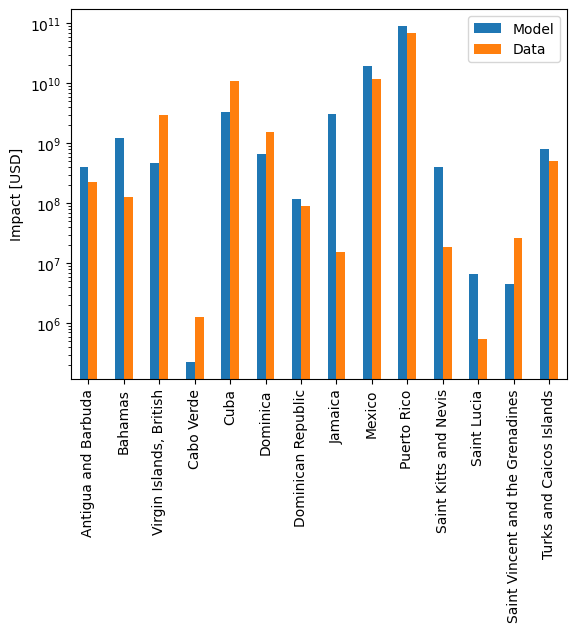

In [24]:
output_eval.plot_at_event(
    data_transf=lambda x: x.rename(index=event_id_to_name), logy=True
)
output_eval.plot_at_region(
    data_transf=lambda x: x.rename(index=country_code_to_name), logy=True
)

Finally, we can do an event- *and* country-based comparison using a heatmap using {py:meth}`~climada.util.calibrate.base.OutputEvaluator.plot_event_region_heatmap`
Since the magnitude of the impact values may differ strongly, this method compare them on a logarithmic scale.
It divides each modelled impact by the observed impact and takes the the decadic logarithm.
The result will tell us how many orders of magnitude our model was off.
Again, the considerations for "nicer" index and columns apply.

<Axes: >

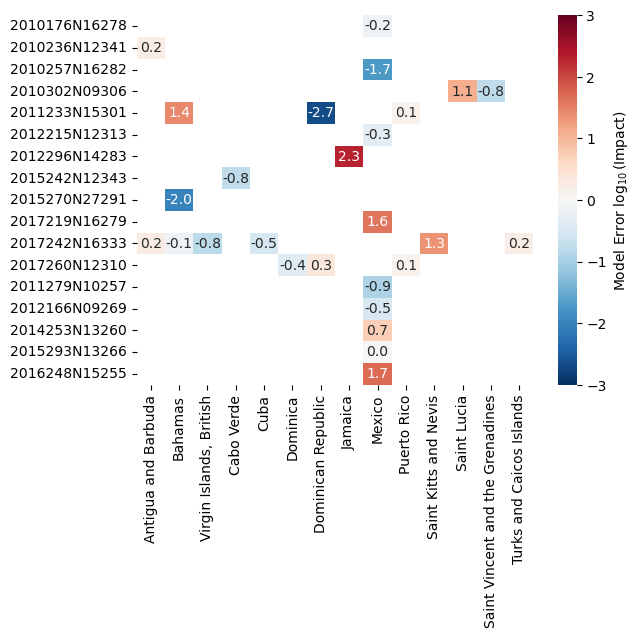

In [25]:
output_eval.plot_event_region_heatmap(
    data_transf=lambda x: x.rename(index=event_id_to_name, columns=country_code_to_name)
)

## Handling Missing Data

NaN-valued input data has a special meaning in calibration: It implies that the impact calculated by the model for that data point should be ignored.
Opposed to that, a value of zero indicates that the model should be calibrated towards an impact of exactly zero for this data point.

There might be instances where data is provided for a certain region or event, and the model produces no impact for them.
This is always treated as an impact of zero during the calibration.
Likewise, there might be instances where the model computes an impact for a region for which no impact data is available.
In these cases, {py:attr}`~climada.util.calibrate.base.Input.missing_data_value` of {py:class}`~climada.util.calibrate.base.Input` is used as fill value for the data.
According to the data value logic mentioned above, `missing_data_value=np.nan` (the default setting) will cause the modeled impact to be ignored in the calibration.
Setting `missing_data_value=0`, on the other hand, will calibrate the model towards zero impact for all regions or events where no data is supplied.

Let's exemplify this with a subset of the data used for the last calibration.
Irma is the cyclone with ID `2017242N16333`, and it hit most locations we were looking at before.
It has the event ID `1454` in our setup.
Let's just use this hazard and the related data for now.

NOTE: We must pass a dataframe to the input, but selecting a single row or column will return a Series.
We expand it into a dataframe again and make sure the new frame is oriented the correct way.

In [26]:
hazard_irma = all_tcs.select(event_names=["2017242N16333"])
data_irma = data.loc[1454, :].to_frame().T
data_irma

region_id,28,44,92,132,192,212,214,388,484,630,659,662,670,796
1454,211176356.8,1801876.321,3.000000e+09,NaN,1.099275e+10,NaN,NaN,NaN,NaN,NaN,18484889.46,NaN,NaN,500000000.0


Let's first calibrate the impact function only on this event, including all data we have.

In [ ]:
from climada.util.calibrate import (
    Input,
    BayesianOptimizer,
    OutputEvaluator,
    BayesianOptimizerOutputEvaluator,
)
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt


def calibrate(hazard, data, **input_kwargs):
    """Calibrate using custom hazard and data"""
    # Define calibration input
    input = Input(
        hazard=hazard,
        exposure=exposure,
        data=data,
        impact_func_creator=impact_func_tc,
        cost_func=mean_squared_log_error,
        impact_to_dataframe=lambda imp: imp.impact_at_reg(exposure.gdf["region_id"]),
        bounds=bounds,
        **input_kwargs,
    )

    # Create and run the optimizer
    with log_level("INFO", name_prefix="climada.util.calibrate"):
        opt = BayesianOptimizer(input)
        controller = BayesianOptimizerController.from_input(input)
        bayes_output = opt.run(controller=controller)

    # Evaluate output
    output_eval = OutputEvaluator(input, bayes_output)
    output_eval.impf_set.plot()

    plt.figure()  # New figure because seaborn.heatmap draws into active axes
    output_eval.plot_event_region_heatmap(
        data_transf=lambda x: x.rename(
            index=event_id_to_name, columns=country_code_to_name
        )
    )

    return bayes_output.params  # The optimal parameters

2025-04-25 14:27:18,449 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 0
2025-04-25 14:27:20,708 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 1
2025-04-25 14:27:23,082 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 2
2025-04-25 14:27:25,550 - climada.util.calibrate.bayesian_optimizer - INFO - No improvement. Stop optimization.


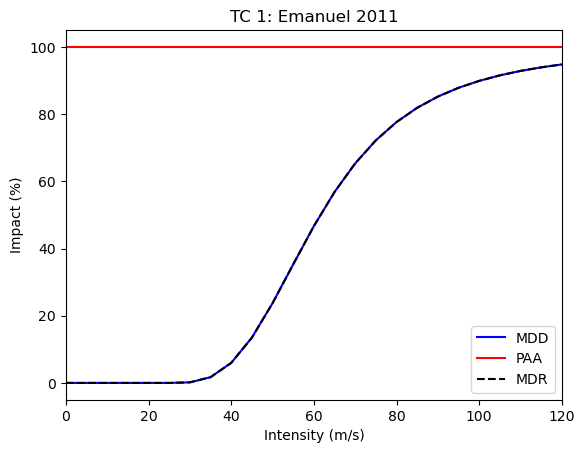

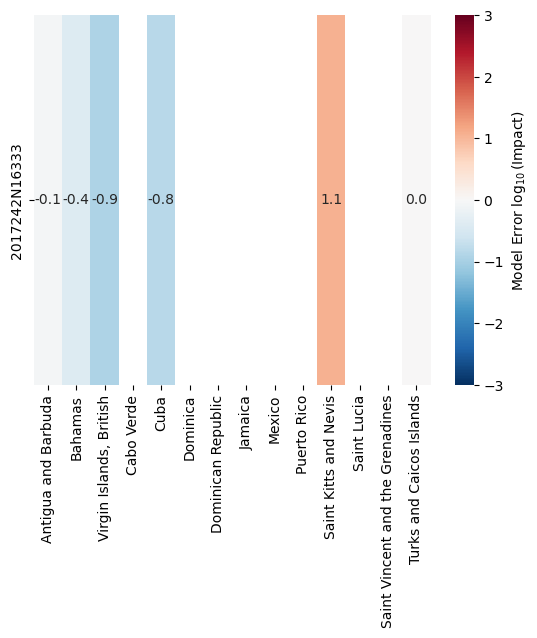

In [28]:
param_irma = calibrate(hazard_irma, data_irma)

If we now remove some of the damage reports and repeat the calibration, the respective impact computed by the model will be ignored.
For Saint Kitts and Nevis, and for Turks and the Caicos Islands, the impact is overestimated by the model.
Removing these regions from the estimation should shift the estimated parameters accordingly, because by default, impacts for missing data points are ignored with `missing_data_value=np.nan`.

2025-04-25 14:27:38,008 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 0
2025-04-25 14:27:40,210 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 1
2025-04-25 14:27:42,394 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 2
2025-04-25 14:27:44,707 - climada.util.calibrate.bayesian_optimizer - INFO - No improvement. Stop optimization.


{'scale': 1.0, 'v_half': 44.48812601602297}

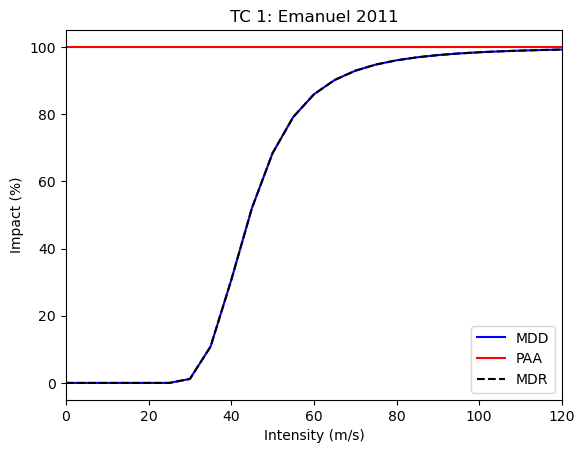

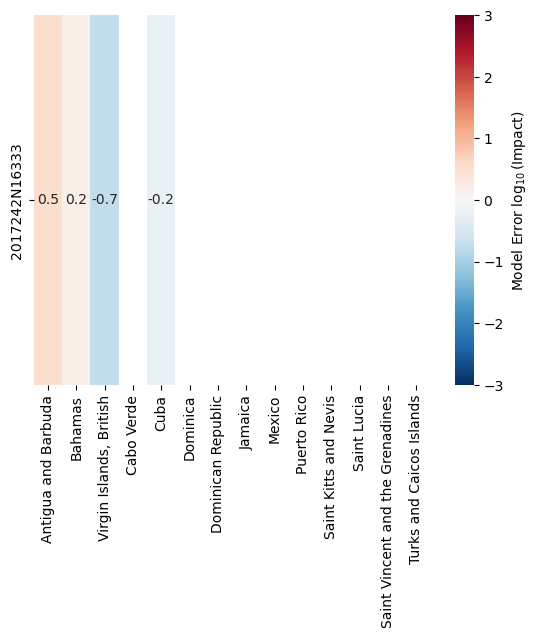

In [29]:
calibrate(hazard_irma, data_irma.drop(columns=[659, 796]))

However, the calibration should change into the other direction once we require the modeled impact at missing data points to be zero:

2025-04-25 14:27:58,736 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 0
2025-04-25 14:28:01,264 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 1
2025-04-25 14:28:04,332 - climada.util.calibrate.bayesian_optimizer - INFO - Optimization iteration: 2
2025-04-25 14:28:07,387 - climada.util.calibrate.bayesian_optimizer - INFO - No improvement. Stop optimization.


{'scale': 0.029173288291594105, 'v_half': 110.11137319113446}

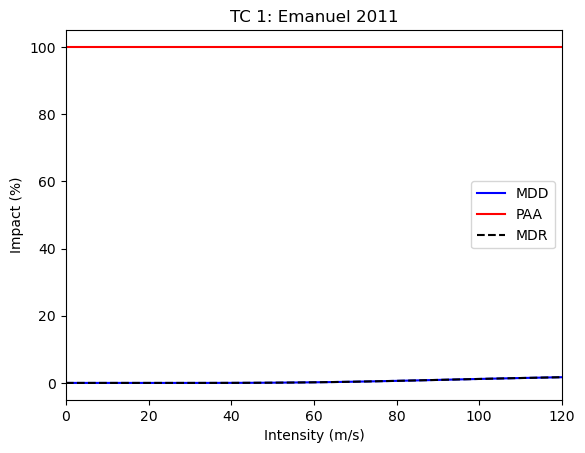

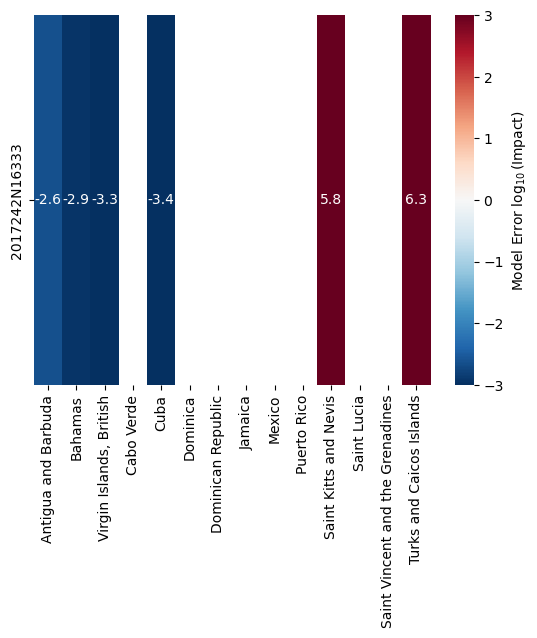

In [30]:
calibrate(hazard_irma, data_irma.drop(columns=[659, 796]), missing_data_value=0)

Actively requiring that the model calibrates towards zero impact in the two dropped regions means that it will typically strongly overestimate the impact there (because impact actually took place).
This will "flatten" the vulnerability curve, causing strong underestimation in the other regions.

## How to Continue

While the found impact function looks reasonable, we find that the model overestimates the impact severely for several events.
This might be due to missing data, but it is also strongly related to the choice of impact function (shape) and the particular goal of the calibration task.

The most crucial information in the calibration task is the cost function.
The RMSE measure is sensitive to the largest errors (and hence the largest impact).
Therefore, using it in the calibration minimizes the overall error, but will incorrectly capture events with impact of lower orders of magnitude.
Using a cost function based on the ratio between modelled and observed impact might increase the overall error but decrease the log-error for many events.

So we present some ideas on how to continue and/or improve the calibration:

1. Run the calibration again, but change the number of initial steps and/or iteration steps.
2. Use a different cost function, e.g., an error measure based on a ratio rather than a difference.
3. Also calibrate the `v_thresh` parameter. This requires adding constraints, because `v_thresh` < `v_half`.
4. Calibrate different impact functions for houses in Mexico and Puerto Rico within the same optimization task.
5. Employ the {py:class}`~climada.util.calibrate.scipy_optimizer.ScipyMinimizeOptimizer` instead of the `BayesianOptimizer`.

## Ensemble Calibration

The parameter space of a single calibration task gives an estimate of the uncertainty within that calibration.
However, it only gives limited information on the uncertainty stemming from the model setup and impact data provided.
To estimate the full model-chain uncertainty, we provide additional method for calibrating ensembles of impact functions based on subsets of the full impact data.

We define two types of ensembles and hence calibration tasks:
* The *average ensemble* (AE) collects impact functions that are calibrated on sampled subsets of the impact data.
* The *ensemble of tragedies* (EoT) collects impact functions that are calibrated on a single impact record each.

We provide two classes that calibrate these types of ensembles, namely {py:class}`~climada.util.calibrate.ensemble.AverageEnsembleOptimizer` and {py:class}`~climada.util.calibrate.ensemble.TragedyEnsembleOptimizer`.
These classes define how the impact data is sampled for each individual impact function calibration task, and then defer this task to an underlying optimizer (which we showcased before).
Both take {py:class}`~climada.util.calibrate.base.Input` object that could also be used in a single calibration optimizer.

### Average Ensemble

For each calibration of the AE, we sample the impact data by drawing a fraction of all impact values.
In this case, let's draw the default 80% with an ensemble size of 5, meaning that we compute 5 distinct impact functions.
As underlying optimizer, we again choose the {py:class}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizer`.
The {py:class}`~climada.util.calibrate.bayesian_optimizer.BayesianOptimizerController` is passed via the ``optimizer_run_kwargs`` argument of {py:meth}`~climada.util.calibrate.ensemble.EnsembleOptimizer.run`.
Note that you must provide the *type*  of the underlying optimizer when constructing an `EnsembleOptimizer`.

In [31]:
from climada.util.calibrate import (
    Input,
    AverageEnsembleOptimizer,
    BayesianOptimizer,
    BayesianOptimizerController,
)
from climada.util import log_level

from sklearn.metrics import mean_squared_log_error

# Define calibration input
with log_level("WARNING", name_prefix="climada.util.calibrate"):
    input = Input(
        hazard=hazard,
        exposure=exposure,
        data=data,
        impact_func_creator=impact_func_tc,
        cost_func=mean_squared_log_error,
        impact_to_dataframe=lambda imp: imp.impact_at_reg(exposure.gdf["region_id"]),
        bounds=bounds,
    )

    # Create and run the optimizer
    opt_ae = AverageEnsembleOptimizer(
        input, optimizer_type=BayesianOptimizer, ensemble_size=10
    )
    controller = BayesianOptimizerController.from_input(input)
    output_ae = opt_ae.run(controller=controller)

100%|██████████| 10/10 [02:03<00:00, 12.38s/it]


The output of an ensemble optimizer is different from that of a single optimizer.
Instead of the parameter space for each optimization we only provide the best estimate of each iteration, along with some information on the events and regions the particular function was calibrated on.
We also provide methods for plotting the resulting ensemble of impact functions.

In [32]:
output_ae.data

Parameters                                                         Event  \
       scale     v_half                                           event_id   
0   0.837499  46.461399  [1333, 1339, 1344, 1351, 1361, 3686, 3691, 374...   
1   0.239009  41.636576  [1339, 1351, 1361, 3686, 3691, 1377, 1390, 374...   
2   0.104654  30.352453  [1333, 1339, 1344, 1351, 1361, 3686, 3691, 137...   
3   0.880125  47.469999  [1333, 1344, 1351, 1361, 3691, 1377, 1390, 142...   
4   1.000000  52.683885  [1333, 1339, 1344, 1351, 1361, 3691, 1377, 139...   
5   1.000000  54.416034  [1333, 1339, 1344, 1351, 1361, 3691, 1377, 374...   
6   1.000000  51.411454  [1339, 1344, 1361, 3686, 3691, 1390, 3743, 142...   
7   1.000000  61.782055  [1339, 1344, 1351, 1361, 1377, 1390, 3743, 142...   
8   1.000000  54.942273  [1333, 1351, 1361, 3686, 3691, 1377, 1390, 142...   
9   0.094194  30.650607  [1333, 1339, 1344, 1351, 1361, 3686, 3691, 139...   

                                                      \
                                           region_id   
0  [28, 44, 92, 132, 212, 214, 484, 630, 659, 662...   
1  [28, 44, 132, 192, 212, 214, 388, 484, 630, 65...   
2  [28, 44, 92, 132, 192, 212, 214, 388, 484, 630...   
3  [28, 44, 92, 132, 192, 212, 214, 388, 484, 630...   
4  [28, 44, 92, 132, 212, 214, 388, 484, 630, 662...   
5  [28, 44, 92, 132, 192, 212, 214, 484, 630, 659...   
6  [28, 44, 92, 132, 192, 212, 214, 388, 484, 630...   
7  [28, 44, 92, 192, 212, 214, 388, 484, 630, 659...   
8  [28, 44, 92, 192, 212, 214, 388, 484, 630, 659...   
9  [28, 44, 92, 132, 214, 388, 484, 630, 659, 670...   

                                                      
                                          event_name  
0  [2010176N16278, 2010236N12341, 2010257N16282, ...  
1  [2010236N12341, 2010302N09306, 2011233N15301, ...  
2  [2010176N16278, 2010236N12341, 2010257N16282, ...  
3  [2010176N16278, 2010257N16282, 2010302N09306, ...  
4  [2010176N16278, 2010236N12341, 2010257N16282, ...  
5  [2010176N16278, 2010236N12341, 2010257N16282, ...  
6  [2010236N12341, 2010257N16282, 2011233N15301, ...  
7  [2010236N12341, 2010257N16282, 2010302N09306, ...  
8  [2010176N16278, 2010302N09306, 2011233N15301, ...  
9  [2010176N16278, 2010236N12341, 2010257N16282, ...

<Axes: title={'center': 'TC 1'}, xlabel='Intensity [m/s]', ylabel='Impact'>

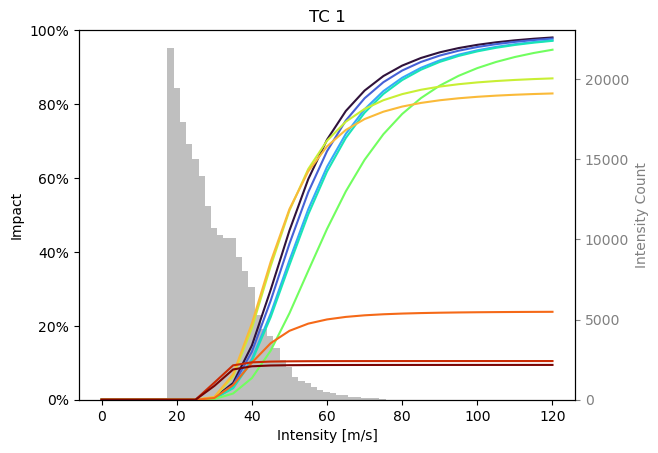

In [33]:
output_ae.plot_shiny(
    impact_func_creator=impact_func_tc,
    haz_type="TC",
    impf_id=1,
    inp=input,
    legend=False,
)

As you can see, although each subset of the calibration data contains 80% of all impact values, the functions differ quite a lot.
We can investigate exactly which impact records cause this through the ensemble of tragedies.
It can be calibrated the same way.
By default, it computes one function for every data point in `data`.

In [34]:
from climada.util.calibrate import TragedyEnsembleOptimizer

# Define calibration input
with log_level("WARNING", name_prefix="climada.util.calibrate"):
    input = Input(
        hazard=hazard,
        exposure=exposure,
        data=data,
        impact_func_creator=impact_func_tc,
        cost_func=mean_squared_log_error,
        impact_to_dataframe=lambda imp: imp.impact_at_reg(exposure.gdf["region_id"]),
        bounds=bounds,
    )

    # Create and run the optimizer
    opt_eot = TragedyEnsembleOptimizer(input, optimizer_type=BayesianOptimizer)
    controller = BayesianOptimizerController.from_input(input)
    output_eot = opt_eot.run(controller=controller)

 22%|██▏       | 6/27 [00:32<01:50,  5.26s/it]

Data point [ 1.  25.8] is not unique. 1 duplicates registered. Continuing ...
Data point [ 1.  25.8] is not unique. 2 duplicates registered. Continuing ...
Data point [ 1.  25.8] is not unique. 3 duplicates registered. Continuing ...


 52%|█████▏    | 14/27 [01:34<01:21,  6.25s/it]

Data point [ 1.  25.8] is not unique. 1 duplicates registered. Continuing ...
Data point [ 1.  25.8] is not unique. 2 duplicates registered. Continuing ...
Data point [ 1.  25.8] is not unique. 3 duplicates registered. Continuing ...


100%|██████████| 27/27 [03:25<00:00,  7.60s/it]


In [35]:
output_eot.data

Parameters                Event                           
        scale      v_half event_id region_id       event_name
0    0.623918   43.558467   [1333]     [484]  [2010176N16278]
1    0.446720   49.853994   [1339]      [28]  [2010236N12341]
2    0.870346   30.882206   [1344]     [484]  [2010257N16282]
3    0.332453   68.510883   [1351]     [662]  [2010302N09306]
4    0.659666   38.132968   [1351]     [670]  [2010302N09306]
5    0.501478   92.838101   [1361]      [44]  [2011233N15301]
6    1.000000   25.800000   [1361]     [214]  [2011233N15301]
7    0.577457   50.142499   [1361]     [630]  [2011233N15301]
8    0.285608   31.604609   [3686]     [484]  [2011279N10257]
9    0.257775   30.957414   [3691]     [484]  [2012166N09269]
10   0.409814   40.494643   [1377]     [484]  [2012215N12313]
11   0.455964  148.659015   [1390]     [388]  [2012296N14283]
12   0.190400   50.537864   [3743]     [484]  [2014253N13260]
13   0.665652   37.430581   [1421]     [132]  [2015242N12343]
14   1.000000   25.800000   [1426]      [44]  [2015270N27291]
15   0.563058   46.037049   [3777]     [484]  [2015293N13266]
16   0.522021  112.298359   [3795]     [484]  [2016248N15255]
17   1.000000  117.135848   [1450]     [484]  [2017219N16279]
18   0.473914   50.544738   [1454]      [28]  [2017242N16333]
19   0.193221   30.347552   [1454]      [44]  [2017242N16333]
20   1.000000   32.463875   [1454]      [92]  [2017242N16333]
21   0.482094   30.424033   [1454]     [192]  [2017242N16333]
22   0.142128   69.089890   [1454]     [659]  [2017242N16333]
23   1.000000   62.107956   [1454]     [796]  [2017242N16333]
24   1.000000   26.131008   [1458]     [212]  [2017260N12310]
25   0.399726   51.035757   [1458]     [214]  [2017260N12310]
26   0.554834   37.334453   [1458]     [630]  [2017260N12310]

<Axes: title={'center': 'TC 1'}, xlabel='Intensity [m/s]', ylabel='Impact'>

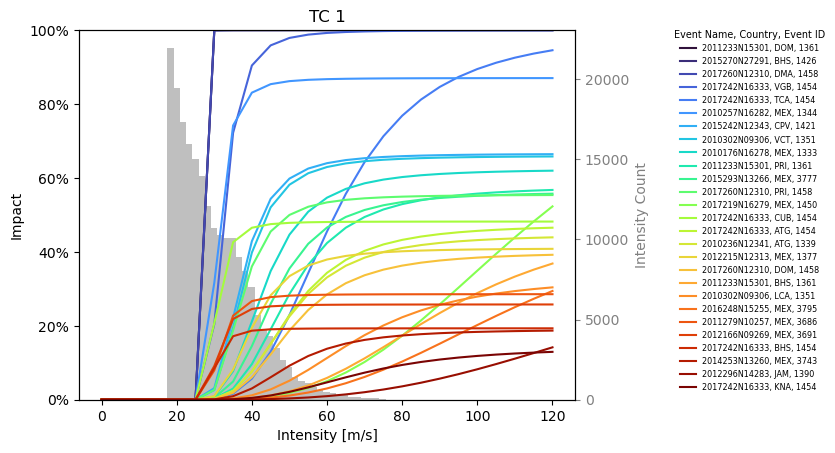

In [37]:
output_eot.plot_shiny(
    impact_func_creator=impact_func_tc,
    haz_type="TC",
    impf_id=1,
    inp=input,
    legend=True,
)

The `plot_category` function helps to differentiate between impact functions by plotting functions of one category with the same color.
Any data in the `Event` column of the `data` attribute in the output data may be used.

<Axes: xlabel='Intensity [m/s]', ylabel='Impact'>

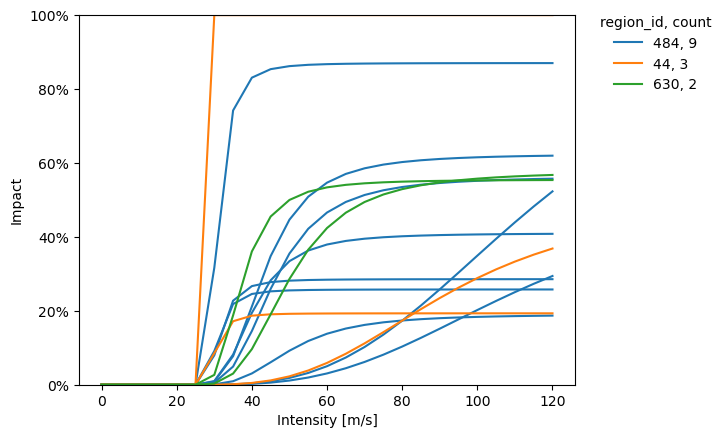

In [44]:
from climada.util.coordinates import country_to_iso


def to_iso(country):
    return country_to_iso(country, "numeric")


output_eot.plot_category(
    impact_func_creator=impact_func_tc,
    haz_type="TC",
    impf_id=1,
    category="region_id",
    category_colors={to_iso("MEX"): "C0", to_iso("BHS"): "C1", to_iso("PRI"): "C2"},
)